In [1]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
from pycbc.psd import estimate
from pycbc.types import TimeSeries
import emcee
import corner
import time
from multiprocessing import Pool
from multiprocessing import cpu_count

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
ncpu = cpu_count()
print(ncpu)

12


# In the cell i am sorting the data to window and limit between 30-1000hz and defining psd to the right shape

In [3]:
# loading in data 
time_data, strain_data = np.loadtxt('data/PE_white_data_ts.txt',skiprows = 1).T
time_noise, strain_noise = np.loadtxt('data/PE_white_noise_ts.txt',skiprows=1).T


# converting to time series
strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])


# rolling to the middle and windowing and rolling back to 8 seconds
mid_point = len(strain_data) /2
final_point = len(strain_data)
peaks,_ = find_peaks(strain_data,height = 3e-21,distance = 1000)
roll_amount = mid_point - peaks
centred = np.roll(strain_data,int(roll_amount))
delta_t = time_data[1] - time_data[0]
window = signal.windows.hann(len(centred))
centred_windowed_signal = centred*window
centred_windowed_signal_final = np.roll(centred_windowed_signal,-int(roll_amount))


#defining main data and shaping
data_freq = np.fft.rfft(centred_windowed_signal_final) 
freq_array = np.fft.rfftfreq(len(time_data),delta_t)

delta_f = freq_array[1]-freq_array[0]

high_cutoff = 1000
low_cutoff = 30

high_limit = 800/delta_f+1
low_limit = 30/delta_f

data_final = data_freq[:int(high_limit)]
freq_final = freq_array[:int(high_limit)]

data_final[freq_final < low_cutoff] = 0 

#defing psd
delta_t = time_data[1] - time_data[0]
duration = len(strain_data)*delta_t
seg_len = len(strain_noise_ts) // 4
seg_stride = seg_len // 2

psd = estimate.welch(strain_noise_ts,window = 'hann' ,seg_len=seg_len,seg_stride = seg_stride)
psd_freqs = np.fft.fftfreq(len(psd), d=delta_t)  

interp_psd = interp1d(psd_freqs, psd, kind='linear', bounds_error=False, fill_value="extrapolate")
psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 


8001


/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


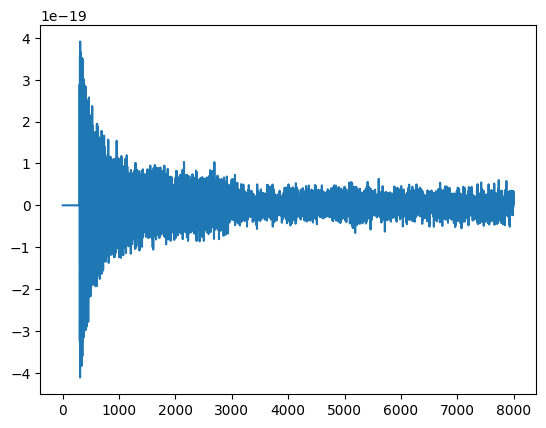

In [4]:
plt.plot(data_final)
print(len(data_final))

# defining the template

In [12]:
def template(theta,delta_t,f_lower,f_higher,time_shift,delta_f):
    M1 = theta 

    hplus , hc = get_fd_waveform(mass1 = M1,mass2 = 30,distance = 100,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t, delta_f = delta_f)
    
    hplus= hplus.cyclic_time_shift(time_shift)

    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
        window_temp = signal.windows.hann(len(hplus))
        hplus = hplus*window_temp
    return hplus
    
    # below is code to fix it but dont think i should have it.
    # if len(hplus) == len(data_final):
    #     return hplus
    # if len(hplus) < len(data_final):
    #     pad_amount = len(data_final) - len(hplus)
    #     hplus = np.pad(hplus,(0,pad_amount),'constant',constant_values=(0,0))
    #     return hplus

8193


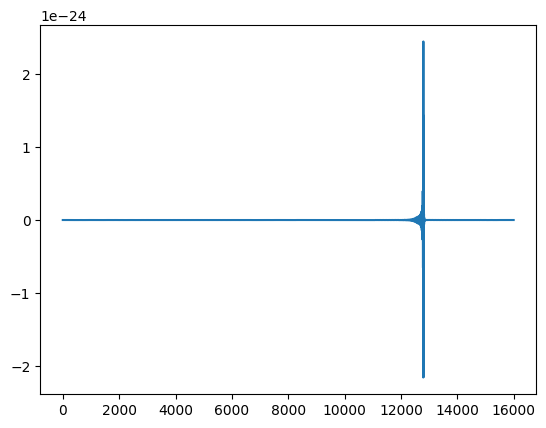

In [13]:
theta = 32    
hplus , hc = get_fd_waveform(mass1 = 20,mass2 = 30,distance = 1024,approximant='IMRPhenomPv2',f_lower=30, f_higher=1000, delta_t = delta_t, delta_f = delta_f)
print(len(hplus))
te = template(theta, delta_t,30,1024,8,delta_f)
# print(te)
# plt.plot(te)
plt.plot(np.fft.irfft(te))



# Defining the prior in log space

In [58]:
def log_prior(theta):
    M1 = theta
    if 20 < M1 < 44:
        return 0.0  # Flat prior (log(1) = 0)
    # print(f"Invalid theta: {theta}")
    return -np.inf

# Defining the log likelihood function

In [85]:
def log_like(theta, fft_signal,noise ,delta_t,delta_f):

    
    temp = template(theta, delta_t , 30, 1024,8,delta_f)

    residual = fft_signal*delta_t - temp*delta_t
    sum = np.abs(residual)**2/noise
    return -2 / 10 * np.sum((sum).numpy())

# Defining the log posterior

In [86]:
def log_posterior(theta, data,noise_data,delta_t,delta_f):
    # print(f"Theta: {theta}")
    log_pri = log_prior(theta)
    if np.isinf(log_pri):  # If prior is -inf, return immediately
        return log_pri
    return log_pri + log_like(theta, data, noise_data,delta_t,delta_f)

# running the mcmc

In [87]:
# nwalkers = 30
# ndim = 1

# initial = np.empty((nwalkers, ndim)) 
# initial[:, 0] = np.random.uniform(20, 44, size=nwalkers)

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args = (data_final,psd_interpolated,delta_t,delta_f), pool=pool)
#     start = time.time()
#     sampler.run_mcmc(initial, 2000, progress=True)
#     end = time.time()
#     multi_time = end - start


In [ ]:
# defining the number of walkers in the mcmc chain and th number of dimensions (parameters)
nwalkers = 30
ndim = 1

# defining intitial array of guess (theta guesses)
initial = np.empty((nwalkers, ndim)) 
initial[:, 0] = np.random.uniform(20, 44, size=nwalkers)

#running the emcee sampelr
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated,delta_t,delta_f))

#running the burn - in stage of the mcmc chain to allow the walker tp explore the space
state = sampler.run_mcmc(initial, nsteps = 1500,progress = True)
sampler.reset()
# running the mcmc
nsteps = 2000
sampler.run_mcmc(initial, nsteps,progress = True)

100%|██████████| 2000/2000 [11:11<00:00,  2.98it/s]


State([[31.17672373]
 [23.28955902]
 [28.8381603 ]
 [32.28038149]
 [34.41952596]
 [31.94975576]
 [34.17043485]
 [26.97928362]
 [25.7105346 ]
 [38.41691328]
 [36.69331876]
 [20.43031466]
 [28.99234562]
 [22.95550987]
 [32.45730245]
 [36.05900108]
 [30.52861779]
 [22.71477106]
 [35.21862005]
 [24.8290887 ]
 [34.20402242]
 [34.61883316]
 [28.72300987]
 [29.8160418 ]
 [21.41235528]
 [20.4336821 ]
 [27.09656461]
 [29.46506568]
 [21.14170378]
 [31.06773876]], log_prob=[-30449.44575584 -30450.67657971 -30450.03000621 -30449.38192458
 -30449.76298355 -30449.38140586 -30449.69049655 -30450.47478503
 -30450.60085061 -30451.19951827 -30450.57559152 -30450.7990415
 -30449.98428658 -30450.69572871 -30449.38923219 -30450.33591926
 -30449.56353291 -30450.71106146 -30450.02702568 -30450.62812162
 -30449.69993824 -30449.8247846  -30450.06383101 -30449.74329236
 -30450.78815539 -30450.79909452 -30450.45553676 -30449.84392203
 -30450.7966399  -30449.4618164 ], blobs=None, random_state=('MT19937', array([

# plotting the mcmc results

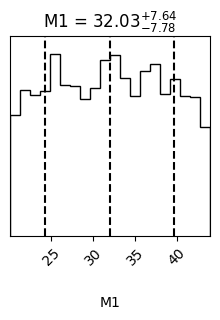

In [ ]:
# this was 10 walkers, 1500 burn in, and 500 steps
samples = sampler.flatchain
figure = corner.corner(samples,labels = ['M1'],quantiles=[0.16,0.5,0.84],show_titles = True)

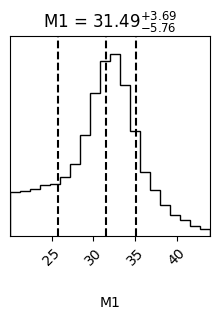

In [89]:
# this is 30 walkers, 1500 burn in and 2000 steps
samples = sampler.flatchain
figure = corner.corner(samples,labels = ['M1'],quantiles=[0.16,0.5,0.84],show_titles = True)

# __________________________________________________________

In [ ]:
def template(theta,delta_t,f_lower,f_higher,time_shift):#,delta_f):
    M1 = theta 
    hplus , hc = get_fd_waveform(mass1 = M1,mass2 = 30,distance = 100,approximant='IMRPhenomPv2',f_lower=f_lower, f_higher=f_higher, delta_t = delta_t, delta_f = 0.08)
    hplus= hplus.cyclic_time_shift(time_shift)
    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
    return hplus

[-0.+0.j  0.+0.j  0.+0.j ...  0.+0.j -0.+0.j  0.-0.j]


/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


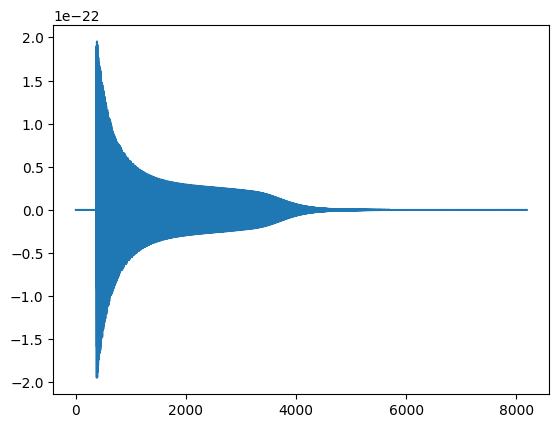

In [41]:
theta = 32
temp = template(theta,delta_t,30,1024,8)

plt.plot(temp)
print(temp)